# Outline for Blog
0. Title 
    - predciting case counts, 
    - focus more on covid/general infectious disease, 
    - data driven sequential models
1. Intro ✔ 
    - A bit of epidemic prediction motivation✔
    - Why look at flu data✔
2. Discuss the dataset ✔
    - Define which components of the data we are looking at✔
3. Go over common methods for studying epidemics ✔
    - SIR ✔
    - LSTM ✔
4. Go over Seq2Seq and why it is a good set up for this problem ✔
    - Compare results ✔
5. Application of method to COVID-19
    - Prediction based data from states ✔
        - long-term (~6 weeks) ✔
        - More state examples: NY, TX, AL  ✔
        - Moving average (on prediction not training) ✔
    - Can we predict which prevention strategy was used from the data? - kinda
        - found better point system for this with US data
        - try again with seq2seq ✔
        - what is a better way to answer this question?
6. Using model trained of flu data with few-shot for covid data ✔
    - trained flu model on data from a few states
    - looked at three day moving average predictions

# Epidemic Prediction: Comparing Data Driven Sequential Models to Traditional Modeling Techniques

In the time of COVID-19, the need for accurate predictions of both long-term and short-term behavior of epidemics has been made apparent. In order to determine which methods may be most useful in making predictions, we first aim to study a similar virus with more robust data.

## The Data
The Centers for Disease Control and Prevention (CDC) has surveillence systems in place for tracking the seasonal spread of influenza. One such network is the US Outpaitent Influenza-like Illness Surveillance Network (ILINet). Each week, outpatient healthcare providers in ILINET report 
- The total number of patients seen for any reason
- The number of those patients with influenza-like illness (ILI) by age group

ILI is defined by
- Fever
- Cough and/or sore throat with out a known cause other than flu

ILINet provides data on a national, state, and regional level as well as percentages of visits due to ILI weighted by population and unweighted. We will be looking at the national level data for weekly case counts.

We will compare predictions of seasonal influenza from SIR models with Recurrent Neural Networks, Long Short Term Memory networks (LSTMs) and Seq2Seq networks, on this data.

### Step 1: Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full_seasons =ilinet_full[0:782] #ignoring current season for now
data = ilinet_full_seasons['ILITOTAL'].values
weeks = ilinet_full_seasons['WEEK'].values[0:52]
plt.plot(data)
plt.title("ILINet Data 2004-2019")
plt.ylabel("Number of Patients for ILI")
plt.show()

<Figure size 640x480 with 1 Axes>

We can see that influenza epidemics follow a similar pattern. Furthermore, we can see that 
- We are dealing with time-series data
- Most seasons are similar to the previous season.

To make the data easier to work with, we change the format to be seasonal.

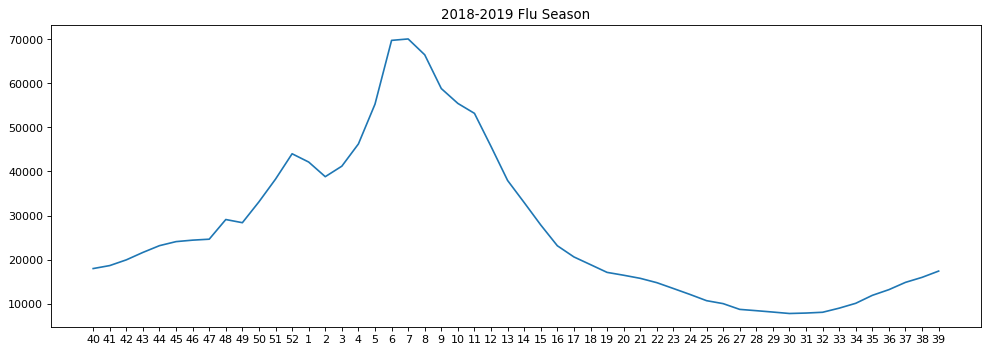

In [2]:
import numpy as np
end_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 39].tolist()
start_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 40].tolist()

seasons=[]
for i in range(len(start_weeks)):
    c=start_weeks[i]
    seasons.append(data[c:c+52])
    
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(seasons[-1])
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.title("2018-2019 Flu Season")
seasons=np.vstack(seasons)

## The SIR Model
The SIR model is a system of ordinary differential equations (ODEs) that have traditionaly been used to study the dynamics of epidemics.

In this model, the population is divided into three groups: Susceptible, Infected, and Recovered. A flow diagram of this model can be seen below.
![title](SIRmodel.png)
Susceptibles become infected with rate $\beta$, and infected recover with rate $\gamma$.

In order to use the SIR model to make predictions, we must optimize the parameters of the model to fit the data. The parameters we optimize include
- % of the population that is initially susceptible
- $\beta$: rate of infection
- $\gamma$: rate of recovery.

### Making predictions using an SIR model

First, we look at making predictions based on the previous season.

We optimize the model parameters to fit the previous season and then use these parameters to run the model and compare the real data.

In [3]:
from scipy.integrate import odeint
from scipy import optimize

# The SIR model differential equations.
def sir_model(y, t, params):
    S, I, R = y
    dSdt = -params[1] * S * I / (params[0]*N)
    dIdt = params[1] * S * I / (params[0]*N) - params[2] * I
    dRdt = params[2] * I
    return (dSdt, dIdt, dRdt)

def run_model(init, p):
    f = lambda y,t: sir_model(y, t, p)
    y0 = p[0]*N, init, 0
    sol = odeint(f, y0, t)
    S, I, R = sol.T
    return I,t

def error_fn(real,model):
    error = real-model
    # Since the peak week of a epidemic is an important feature, 
    # we want to make sure this value is accurate
    error[np.argmax(real)]=error[np.argmax(real)]*1000
    return error

def real_mod_comp(p,real):
    modelI,t = run_model(real[0], p)
    err=error_fn(real,modelI)
    # we want to make sure our parameters are biologically plausible
    if p[0]<0 or p[1]<0 or p[2]<0 or p[0]>1:
        err = err+10**6
    return err

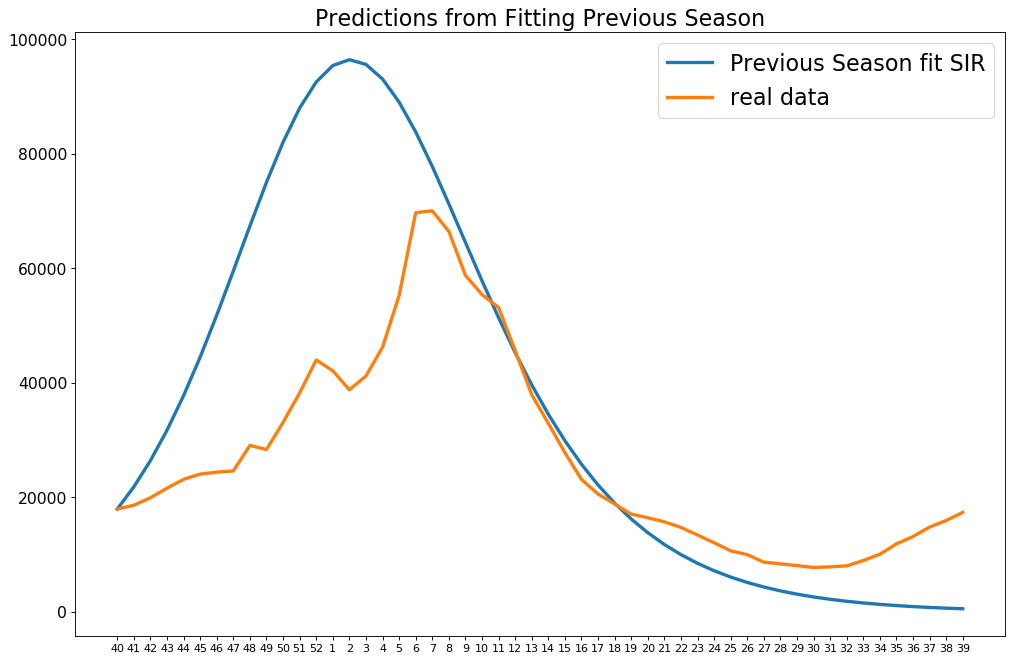

In [4]:
import warnings
warnings.filterwarnings("ignore")

N=300000000 #approximate US pop.
t = np.linspace(0, 52, 52)
p0=[.5,.7, 1./14]

#get parameters from fitting to last season
fn = lambda p: real_mod_comp(p,seasons[-2])
(c,kvg) = optimize.leastsq(fn, p0) 
p_prev=c

I,t=run_model(seasons[-1][0], p_prev)

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)

plt.plot(I, label="Previous Season fit SIR", linestyle='-', linewidth=3)
plt.plot(seasons[-1],label="real data", linewidth=3)
plt.title("Predictions from Fitting Previous Season",fontsize=20)
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.show()

Next, we see how the SIR model does making predictions from only 10 data points. 

We will do this in two ways
- Fitting to the previous season and using these parameters as a starting point for optimization: "Smart SIR"

- Using a general starting point: "Naive SIR"

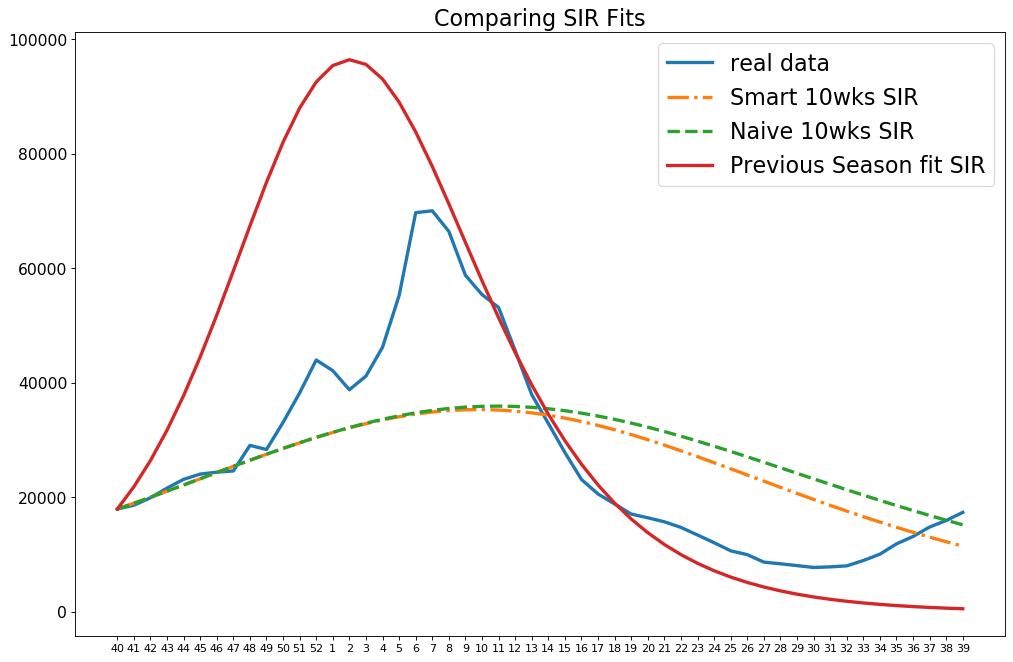

In [5]:
# since we now have only 10 weeks of data, we need to change the error functions
def error_fn_partial(real,model):
    error = real-model
    error[-1]= error[-1]*100 #weight last data point
    return error
def real_mod_comp_partial(p,real):
    c=0
    if p[0]<0 or p[1]<0 or p[2]<0:
        c = 10**10
    model,t = run_model(real[0], p)
    err=error_fn_partial(real,model)+c
    return err

N=300000000
p0=[.5,.7, 1./14]

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1],label="real data", linewidth =3)

numwks=10
t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp_partial(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p_prev) 

t = np.linspace(0, 52, 52)
I2,t=run_model(seasons[-1][0], c)
plt.plot(I2, label="Smart 10wks SIR", linestyle='-.', linewidth =3)

t = np.linspace(0, numwks,numwks)
fn = lambda p: real_mod_comp_partial(p,seasons[-1][0:numwks])
(c,kvg) = optimize.leastsq(fn, p0) 

t = np.linspace(0, 52, 52)
I3,t=run_model(seasons[-1][0], c)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--', linewidth =3)
plt.legend()

plt.plot(I, label="Previous Season fit SIR", linestyle='-', linewidth =3)
plt.title("Comparing SIR Fits",fontsize=20 )
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.show()

In [6]:
print("Difference in Peak Value:")
print("Smart 10wks SIR:",abs(I2.max() - seasons[-1].max()))
print("Previous Season fit SIR:",abs(I.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("Smart 10wks SIR:",abs(np.argmax(I2) - np.argmax(seasons[-1])))
print("Previous Season fit SIR:",abs(np.argmax(I) - np.argmax(seasons[-1])))

Difference in Peak Value:
Smart 10wks SIR: 34705.343451666995
Previous Season fit SIR: 26391.165019990673

Difference in Peak Week:
Smart 10wks SIR: 3
Previous Season fit SIR: 5


The results tell us that using the SIR model fit to the previous season gives us the most overall accurate predictions from this model. However, the model that used only the first 10 weeks was better able to predict the peak week of the epidemic.

## LSTM Network

Another commonly used prediction strategy for time series data, like epidemic data, is reccurent neural networks (RNNs), specifically LSTMs (Long Short-Term Memory units). LSTMs are able to recognize temoporal patterns in time series data that are then used in prediction [1].

This implementation follow this tutorial for time series prediction with LSTM in PyTorch
 - https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

### Normalizing the data for LSTM

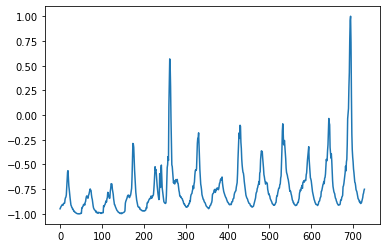

In [70]:
import torch
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
maxval = seasons[0:-1].max()
minval = seasons[0:-1].min()
scaleddata = scaler.fit_transform(seasons.reshape(-1, 1))
full_data = torch.FloatTensor(scaleddata).view(-1)
train_data = full_data[:-52] #removing last season from training data
plt.plot(train_data)
plt.show()

### Creating input-output sequences to train the model
Next, we create tuples that will be used to train the model. These tuples will contain 52 week of data as the input and the following week as the output.

In [71]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 52
train_inout_seq = create_inout_sequences(train_data, train_window)

An example of the input/output sequence is given below. There are 52 data points in each input sequence with one label, which is the next data point.

In [72]:
print(train_inout_seq[0])

(tensor([-0.9482, -0.9377, -0.9287, -0.9207, -0.9165, -0.9069, -0.9065, -0.9128,
        -0.8968, -0.8963, -0.8888, -0.8903, -0.8537, -0.8362, -0.8297, -0.8065,
        -0.7353, -0.6486, -0.5755, -0.5625, -0.6385, -0.7166, -0.7542, -0.8025,
        -0.8394, -0.8756, -0.9104, -0.9189, -0.9332, -0.9373, -0.9524, -0.9519,
        -0.9630, -0.9739, -0.9729, -0.9811, -0.9841, -0.9838, -0.9899, -0.9936,
        -0.9948, -0.9966, -0.9984, -0.9986, -0.9977, -0.9999, -1.0000, -0.9974,
        -0.9968, -0.9976, -0.9932, -0.9935]), tensor([-0.9387]))


Now we construct the model.

In [73]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
model = LSTM()
loss_function = nn.L1Loss()#MSELoss()#L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We train the model on the input/output sequences we created earlier and look at the loss.

In [74]:
epochs = 50
losses=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        losses.append(single_loss)
        single_loss.backward()
        optimizer.step()
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.10815370
epoch:  26 loss: 0.01806527
epoch:  49 loss: 0.0227522254


Epoch with minimum loss:  34


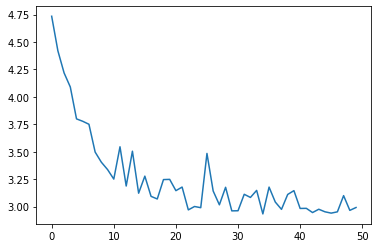

In [75]:
losses=[float(i) for i in losses]
lossperepoch  =[]
sep=int(len(losses)/epochs)
c=0
for i in range(0,len(losses),sep):
    lossperepoch.append(sum(losses[c*sep:c*sep+sep]))
    c=c+1
plt.plot(range(0,epochs),np.log(lossperepoch))
print("Epoch with minimum loss: ",np.argmin(lossperepoch))

Since it looks like the model converges, but the loss it pretty high. Lets see what the predictions for the next season look like.

In [76]:
fut_pred = 52

test_inputs = full_data[-fut_pred:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = np.array(test_inputs[train_window:])

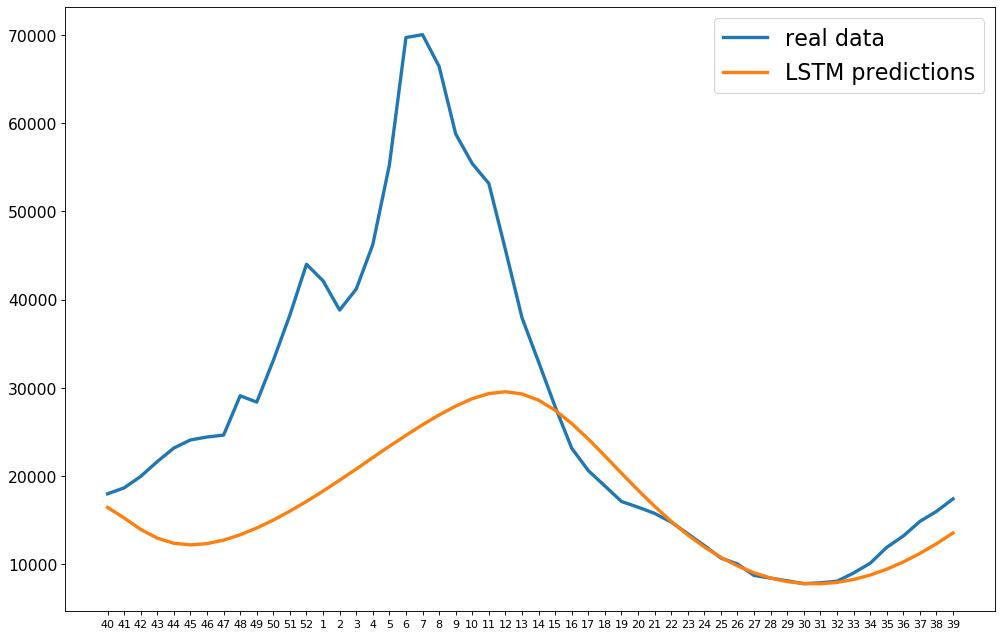

In [77]:
unscaled = scaler.inverse_transform(actual_predictions.reshape(-1, 1))

fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1], label='real data', linewidth=3)
plt.plot(unscaled, label='LSTM predictions',linewidth = 3)
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.show()

There predictions aren't very good, but let's see how they compare to the SIR model.

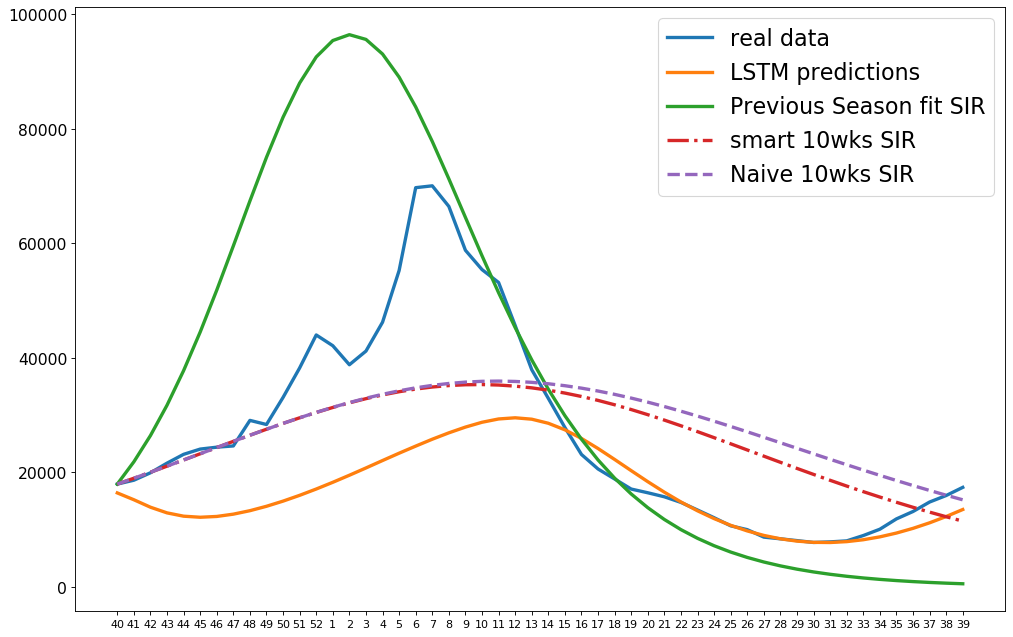

In [81]:
fig=plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1], label='real data',linewidth =3)
plt.plot(unscaled, label='LSTM predictions',linewidth =3)
plt.plot(I, label="Previous Season fit SIR", linestyle='-',linewidth =3)
plt.plot(I2, label="smart 10wks SIR", linestyle='-.', linewidth =3)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--',linewidth =3)
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.show()

In [82]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 40506.40205805003
Best SIR Prediction: 26391.165019990673

Difference in Peak Week:
LSTM Predictions: 5
Best SIR Prediction: 5


**This is doing worse than the SIR model!**

However, we can see that it may be able to fit the shape better. Therefore, we want to see if another RNN will do a better job.

## Seq2Seq Model

Seq2Seq models use RNN encoder and decoder layers that converts one sequence to another. Although this is typically used for language processing, it is also suited to time series forcasting. 

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

The implementation of this model is adapted from 

- https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb

In [177]:
#normalize data
normalized_seasons=(seasons-seasons.min())/(seasons.max()-seasons.min())

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model_flu = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [178]:
def transform_series_encode(series_array):
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - np.zeros([len(encode_series_mean),1])#encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [179]:
encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [180]:
batch_size = 2**11
epochs = 100

encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2] 
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model_flu.compile(Adam(), loss='mean_absolute_error')#'mean_squared_error')
history = model_flu.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Train on 10 samples, validate on 3 samples
Epoch 1/100
10/10 [==============================] - 1s 140ms/step - loss: 0.2982 - val_loss: 0.2772
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2716 - val_loss: 0.2566
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2547 - val_loss: 0.2358
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2354 - val_loss: 0.2146
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2154 - val_loss: 0.1939
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1999 - val_loss: 0.1769
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1782 - val_loss: 0.1629
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1619 - val_loss: 0.1530
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1537 - val_loss: 0.1471
Epoch 10/100
10/10 [==============================] - 0s 5ms/ste

Epoch 83/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0389 - val_loss: 0.0374
Epoch 84/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0349
Epoch 85/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0377 - val_loss: 0.0349
Epoch 86/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0372 - val_loss: 0.0342
Epoch 87/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0361 - val_loss: 0.0335
Epoch 88/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0354 - val_loss: 0.0333
Epoch 89/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0324
Epoch 90/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0375 - val_loss: 0.0313
Epoch 91/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0332 - val_loss: 0.0330
Epoch 92/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0356 - val_loss: 0.0297


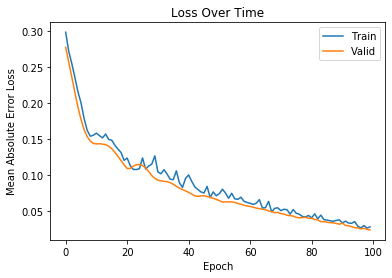

In [181]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])
plt.show()

In [182]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [183]:
encoder_input_data = normalized_seasons[0:-1]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-1]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

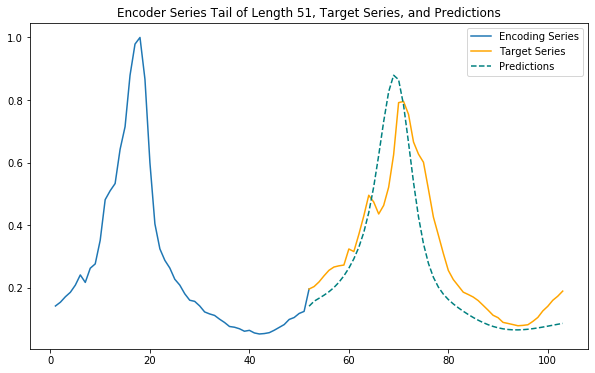

In [184]:
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data, 13)

We can already see that seq2seq is doing much better than our other prediction strategies, but let's visualize this.

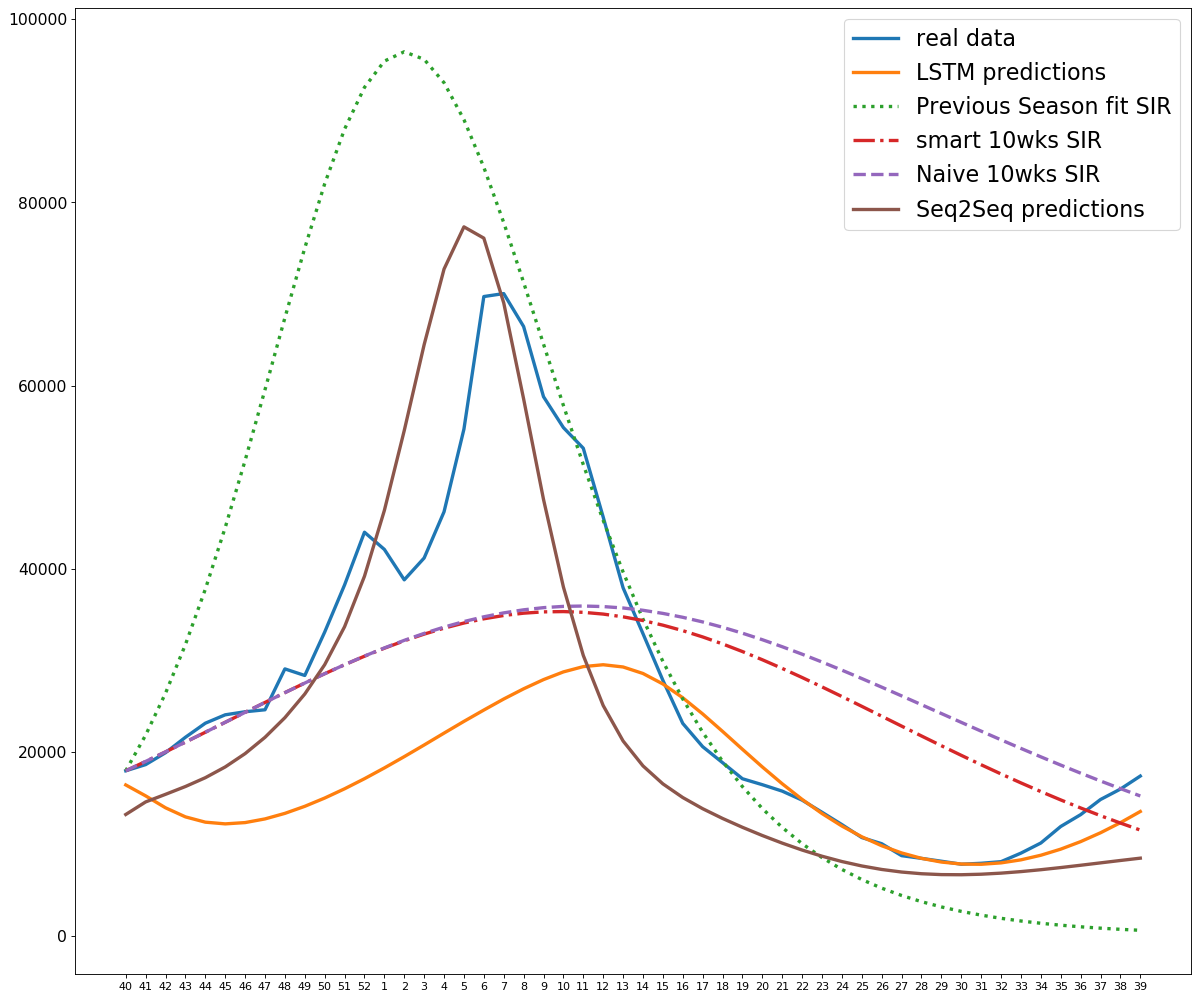

In [185]:
unscaled2 =preds*(seasons.max()-seasons.min())+seasons.min()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
y_pos = np.arange(len(weeks))
plt.xticks(y_pos, weeks)
plt.plot(seasons[-1], label='real data', linewidth =3)
plt.plot(unscaled, label='LSTM predictions', linewidth =3)
plt.plot(I, label="Previous Season fit SIR", linestyle=':', linewidth =3)
plt.plot(I2, label="smart 10wks SIR", linestyle='-.', linewidth =3)
plt.plot(I3, label="Naive 10wks SIR", linestyle='--', linewidth =3)
plt.plot(unscaled2, label='Seq2Seq predictions', linestyle='-', linewidth =3)
plt.legend(prop={'size': 20})
plt.yticks(fontsize=14)
plt.show()

In [186]:
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("Best SIR Prediction:",abs(I.max() - seasons[-1].max()))
print("Seq2Seq Predictions:",abs(unscaled2.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))
print("Best SIR Prediction:",abs(np.argmax(I) - np.argmax(seasons[-1])))
print("Seq2Seq Predictions:",abs(np.argmax(unscaled2) - np.argmax(seasons[-1])))

Difference in Peak Value:
LSTM Predictions: 40506.40205805003
Best SIR Prediction: 26391.165019990673
Seq2Seq Predictions: 7281.0405485630035

Difference in Peak Week:
LSTM Predictions: 5
Best SIR Prediction: 5
Seq2Seq Predictions: 2


The Seq2Seq predictions do significantly better than both SIR and LSTM on predicting the peak value of the epidemic. Furthermore, it does just as well on predicting the peak week as the SIR model.

# Application of Seq2Seq to predict COVID19

Since the results from using seq2seq on the flu data were promising, let's see how well we can predict COVID data. The data used for this application is from the COVID19 Global Forcasting challenge on Kaggle. The data includes confirmed cases and fatalities on a country, county, and state level as well as the population of each region.

### Loading the data

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.DataFrame(pd.read_csv('train.csv'))
data

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
824189,969594,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-18,Fatalities,0.0
824190,969595,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-19,ConfirmedCases,0.0
824191,969596,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-19,Fatalities,0.0
824192,969597,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-20,ConfirmedCases,2.0


Let's focus on the US data for now.

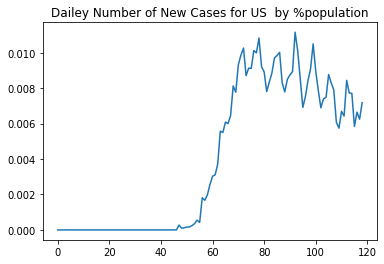

In [188]:
US_data = data.loc[data['Country_Region'] == 'US']
US_data_cases = US_data.loc[US_data['Target'] == 'ConfirmedCases']
US_data_cases = US_data_cases.loc[US_data_cases['Population'] == 324141489]
plt.plot(US_data_cases['TargetValue'].values/324141489*100)
plt.title("Dailey Number of New Cases for US  by %population")
plt.show()

In [189]:
states_train =['Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee',  'Utah', 'Vermont','Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming']
states_test=['Alabama','New York','Texas']
df_train = pd.DataFrame(columns =['Date']+states_train)#columns = states
df_train["Date"] = US_data_cases["Date"].values

df_test = pd.DataFrame(columns =['Date']+states_test)#columns = states
df_test["Date"] = US_data_cases["Date"].values

In [190]:
train_data_as_array=[]
for state in states_train:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_train[state]=state_data_cases['TargetValue'].values
    max_cases = df_train[state].max()
    min_cases = df_train[state].min()
    df_train[state]=(df_train[state]-min_cases)/(max_cases-min_cases)
    train_data_as_array.append(df_train[state].values)
train_data_as_array=np.vstack(train_data_as_array)

In [191]:
test_data_as_array=[]
for state in states_test:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_test[state]=state_data_cases['TargetValue'].values
    max_cases = df_test[state].max()
    min_cases = df_test[state].min()
    df_test[state]=(df_test[state]-min_cases)/(max_cases-min_cases)
    test_data_as_array.append(df_test[state].values)
test_data_as_array=np.vstack(test_data_as_array)

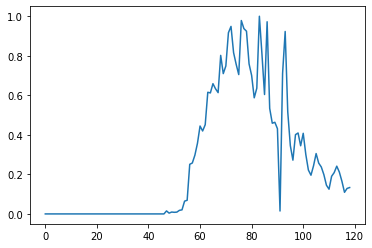

In [192]:
plt.plot(test_data_as_array[1])
plt.show()

### Using Seq2Seq to predict last 45 days of data from training on states


In [196]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")


latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model_covid = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [197]:
def create_encoder_target_pairs(data):
    e_data = []
    t_data = []
    if len(data)!=119:
        for i in range(len(data)):
            e_data.append(data[i][0:-45])
            t_data.append(data[i][-45:])
    else:
        e_data.append(data[0:-45])
        t_data.append(data[-45:])
    return [np.array(e_data),np.array(t_data)]

In [198]:
[e_data,t_data]=create_encoder_target_pairs(train_data_as_array)

In [199]:
batch_size = 2**11
epochs = 100

encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model_covid.compile(Adam(), loss='mean_absolute_error')
history = model_covid.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Train on 38 samples, validate on 10 samples
Epoch 1/100
38/38 [==============================] - 2s 40ms/step - loss: 0.3031 - val_loss: 0.2447
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2677 - val_loss: 0.2179
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2297 - val_loss: 0.1922
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2040 - val_loss: 0.1682
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1855 - val_loss: 0.1498
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1895 - val_loss: 0.1410
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1787 - val_loss: 0.1388
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1951 - val_loss: 0.1380
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1713 - val_loss: 0.1364
Epoch 10/100
38/38 [==============================] - 0s 2ms/ste

Epoch 83/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1566 - val_loss: 0.1482
Epoch 84/100
38/38 [==============================] - 0s 1ms/step - loss: 0.1521 - val_loss: 0.1484
Epoch 85/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1648 - val_loss: 0.1485
Epoch 86/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1576 - val_loss: 0.1486
Epoch 87/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1599 - val_loss: 0.1487
Epoch 88/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1515 - val_loss: 0.1488
Epoch 89/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1548 - val_loss: 0.1488
Epoch 90/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1517 - val_loss: 0.1487
Epoch 91/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1485
Epoch 92/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1520 - val_loss: 0.1482


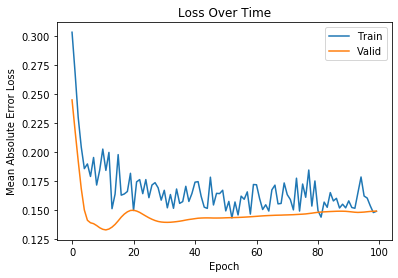

In [200]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [201]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [202]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[0])
encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

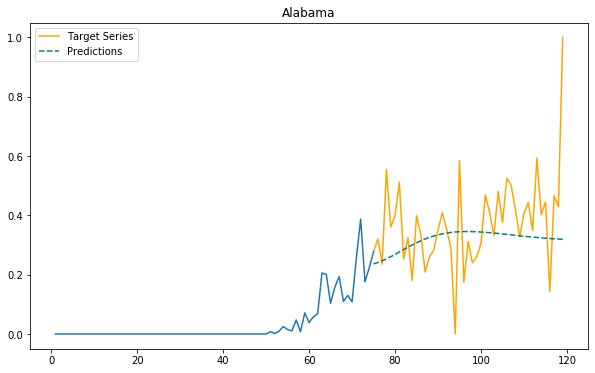

In [203]:
pred_steps=len(t_data[0])
def predict_and_plot(encoder_input_data, decoder_target_data, enc_tail_len=len(encoder_input_data[0])):
    encode_series = encoder_input_data
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data.reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.legend(['Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data)
plt.title("Alabama")
plt.show()

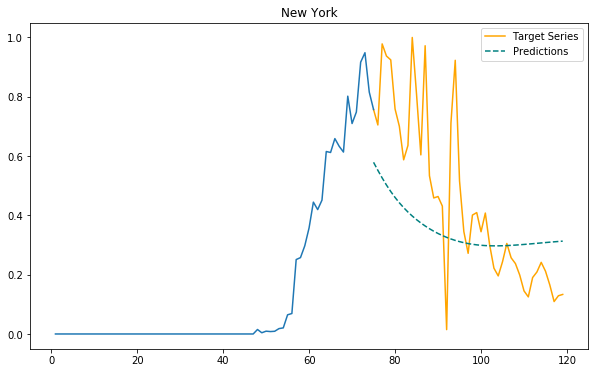

In [204]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[1])
encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
preds= predict_and_plot(encoder_input_data, decoder_target_data)
plt.title("New York")
plt.show()

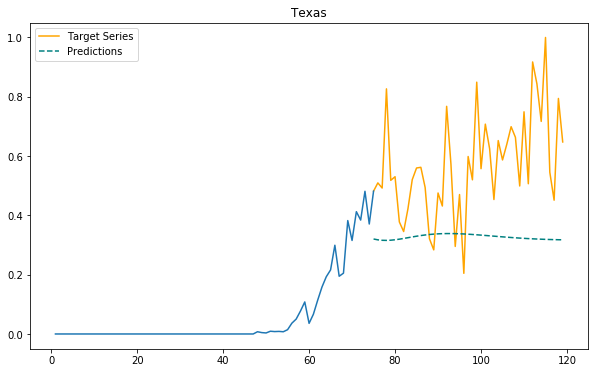

In [205]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[2])
encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
preds= predict_and_plot(encoder_input_data, decoder_target_data)
plt.title("Texas")
plt.show()

We can see that we were not able to capture all of the spikes in the daily number of new cases, but we were able to capture an overall trend. Furthermore, some predictions were more accurate that others. 

However, these are long-term predictions, and we are more interested in short-term predictions. Therefore, we want to look at moving averages, which are updated each day.

### Moving Average Predictions - 3 Day
Here, for each new day of data, we predict three days ahead and average these points.

In [206]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[2])
c = 0
pred_steps=3
preds=[]
for i in range(len(t_data[0])):
    edata = np.array([np.append(e_data[0],t_data[0][0:c])])
    encoder_input_data = edata
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    decoder_target_data = [t_data[0][c:c+pred_steps]]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    preds= np.append(preds,np.mean(decode_sequence(encoder_input_data)))
    c=c+1

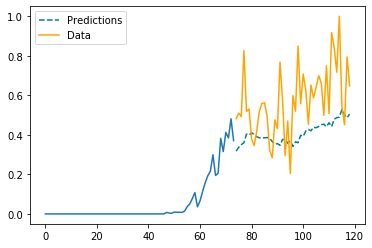

In [207]:
plt.plot(e_data[0])
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),preds,color='teal',linestyle='--', label='Predictions')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),t_data[0],color='orange', label='Data')
plt.legend()
plt.show()

### Moving Average Predictions - 7 Day
For each new day of data, we predict seven days ahead and average these points.

In [208]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array[2])
c = 0
pred_steps=7
preds=[]
for i in range(len(t_data[0])):
    edata = np.array([np.append(e_data[0],t_data[0][0:c])])
    encoder_input_data = edata
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    decoder_target_data = [t_data[0][c:c+pred_steps]]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    preds= np.append(preds,np.mean(decode_sequence(encoder_input_data)))
    c=c+1

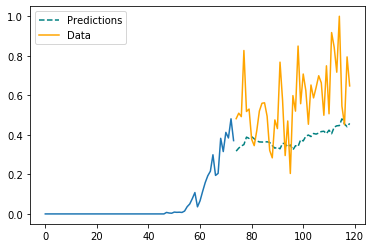

In [209]:
plt.plot(e_data[0])
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),preds,color='teal',linestyle='--', label='Predictions')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(t_data[0])),t_data[0],color='orange', label='Data')
plt.legend()
plt.show()

### Can we predict the prevention strategy used from shape of the epidemic?

WalletHub scored US states on COVID19 strictness out of 100 points using the measures
- requirement to wear a facemask in public
- travel restrictions
- large gatherings restrictions
- statewide school restarts
- reopening of restaurants and bars
- reopening of non-essential businesses
- child care programs reopening
- strictness of "shelter in place" order
- presence of multistate agreements to reopen
- suspension or postponement of legislative sessions
- guidance on elective surgery and medical procedures

**Higher scores indicate a lower level of strictness.**

In [121]:
# scores of states in alphabetica order
state_score_train = np.array([52.09, 59.77, 53.02, 29.54, 30.70,
20.00, 20.47,14.88, 52.09, 37.67,16.05, 71.16, 11.16, 52.56, 58.37,
49.30, 26.05, 35.58, 27.44, 31.86,15.58, 20.00, 39.77, 47.21,
69.07, 66.98, 50.93, 38.37, 26.28,20.47, 16.28, 26.05,
59.54, 24.19, 44.42, 42.33, 42.09, 11.63, 51.74, 86.74, 53.95, 68.84, 15.81, 29.07, 16.28, 53.02,
73.95, 68.72])
state_score_test=np.array([57.44, 20.00,57.21])
maxscore = 86.74
minscore = 11.16
state_score_train =(state_score_train-minscore)/(maxscore-minscore)
state_score_test =(state_score_test-minscore)/(maxscore-minscore)

In [122]:
train_data_as_array=[]
for state in states_train:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_train[state]=state_data_cases['TargetValue'].values/state_pop
    max_cases = df_train[state].max()
    min_cases = df_train[state].min()
    df_train[state]=(df_train[state]-min_cases)/(max_cases-min_cases)
    train_data_as_array.append(df_train[state].values)
train_data_as_array=np.vstack(train_data_as_array)

In [123]:
test_data_as_array=[]
for state in states_train:
    state_data=US_data.loc[US_data['Province_State'] == state]
    state_pop = state_data['Population'].max()
    state_data_cases = state_data.loc[state_data['Target'] == 'ConfirmedCases']
    state_data_cases = state_data_cases.loc[state_data_cases['Population'] == state_pop]
    df_test[state]=state_data_cases['TargetValue'].values/state_pop
    max_cases = df_test[state].max()
    min_cases = df_test[state].min()
    df_test[state]=(df_test[state]-min_cases)/(max_cases-min_cases)
    test_data_as_array.append(df_test[state].values)
test_data_as_array=np.vstack(train_data_as_array)

In [124]:
latent_dim = 50 # LSTM hidden units
dropout = .20 

encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, 1)) 

decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) 
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [125]:
batch_size = 2**11
epochs = 100

encoder_input_data = train_data_as_array
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = state_score_train
                                            
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Train on 38 samples, validate on 10 samples
Epoch 1/100
38/38 [==============================] - 1s 32ms/step - loss: 0.4162 - val_loss: 0.3878
Epoch 2/100
38/38 [==============================] - 0s 2ms/step - loss: 0.3877 - val_loss: 0.3630
Epoch 3/100
38/38 [==============================] - 0s 2ms/step - loss: 0.3628 - val_loss: 0.3388
Epoch 4/100
38/38 [==============================] - 0s 2ms/step - loss: 0.3412 - val_loss: 0.3186
Epoch 5/100
38/38 [==============================] - 0s 2ms/step - loss: 0.3195 - val_loss: 0.3011
Epoch 6/100
38/38 [==============================] - 0s 2ms/step - loss: 0.3015 - val_loss: 0.2854
Epoch 7/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2870 - val_loss: 0.2712
Epoch 8/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2750 - val_loss: 0.2575
Epoch 9/100
38/38 [==============================] - 0s 2ms/step - loss: 0.2601 - val_loss: 0.2482
Epoch 10/100
38/38 [==============================] - 0s 2ms/ste

Epoch 83/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1946 - val_loss: 0.1926
Epoch 84/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1947 - val_loss: 0.1919
Epoch 85/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1934 - val_loss: 0.1916
Epoch 86/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1925 - val_loss: 0.1913
Epoch 87/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1919 - val_loss: 0.1899
Epoch 88/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1914 - val_loss: 0.1892
Epoch 89/100
38/38 [==============================] - 0s 2ms/step - loss: 0.1911 - val_loss: 0.1891
Epoch 90/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1915 - val_loss: 0.1880
Epoch 91/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1904 - val_loss: 0.1872
Epoch 92/100
38/38 [==============================] - 0s 3ms/step - loss: 0.1893 - val_loss: 0.1869


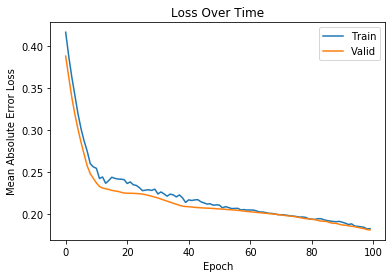

In [126]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [127]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, -1, 0]
    output, h, c = decoder_model.predict([target_seq] + states_value)
    return output[0][0][0]

For Alabama, we predict

In [128]:
encoder_input_data=np.array([test_data_as_array[0]])
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
print(decode_sequence(encoder_input_data))
print(state_score_test[0])

0.54025114
0.6123313045779307


For New York, we predict

In [129]:
encoder_input_data=np.array([test_data_as_array[1]])
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
print(decode_sequence(encoder_input_data))
print(state_score_test[1])

0.5520135
0.11696215930140248


This mean that we predicted New York would have less restrictions than it did.

For Texas, we predict

In [131]:
encoder_input_data=np.array([test_data_as_array[2]])
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
print(decode_sequence(encoder_input_data))
print(state_score_test[2])

0.54363394
0.6092881714739349


From this, we can see that scores for Texas and Alabama were similar to the predicted values. 

However, New York's score was not similar to its predicted value. Let's look at why this may be.

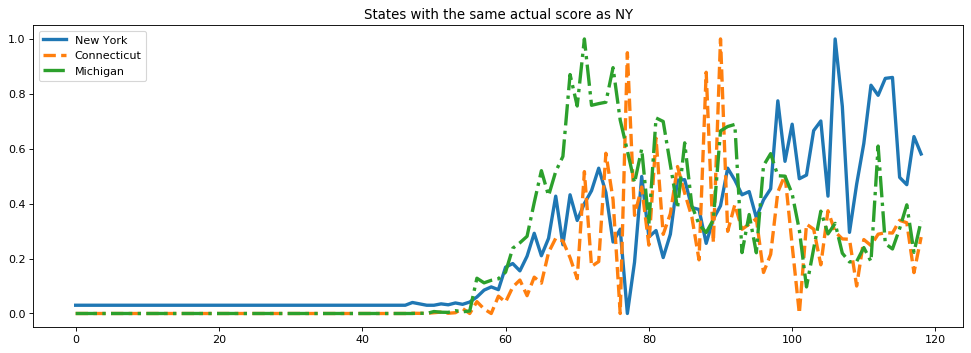

In [132]:
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_data_as_array[1], label = 'New York', linewidth = 3)
plt.plot(train_data_as_array[5], label='Connecticut', linestyle='--', linewidth = 3)
plt.plot(train_data_as_array[21], label='Michigan', linestyle='-.', linewidth = 3)

plt.title('States with the same actual score as NY')
plt.legend()
plt.show()

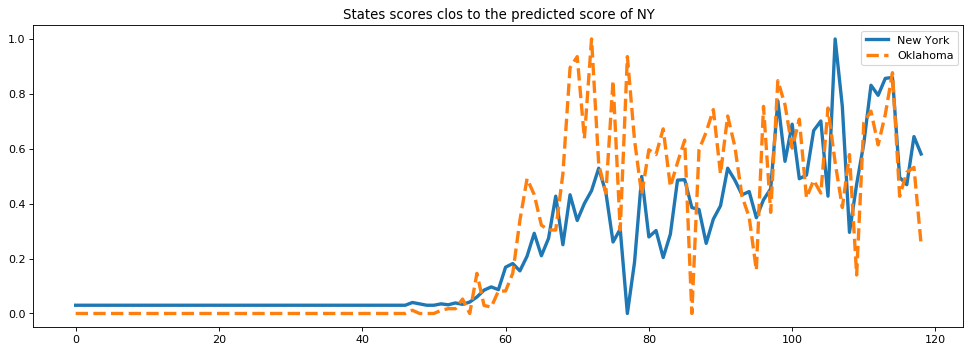

In [133]:
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_data_as_array[1], label = 'New York', linewidth = 3)
plt.plot(train_data_as_array[-14], label='Oklahoma', linewidth = 3, linestyle='--')
plt.title('States scores clos to the predicted score of NY')
plt.legend()
plt.show()

We can see that the outbreak in New York was somewhere in between that in Oklahoma and in Michigan. 

Furthermore, the scores do not take into account when mitigation strategies were implemented which probably plays a lage role in outcome.

### Does flu data give us any intuition on COVID-19 data?
Let's retrain the flu model on data from a few states and see how it does with moving average predictions.

In [210]:
[e_data,t_data]=create_encoder_target_pairs(test_data_as_array) # using three states since we want few-shots

In [211]:
batch_size = 2**11
epochs = 100

encoder_input_data = e_data
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = t_data                   
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [212]:
history = model_flu.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs = 100);

Epoch 1/100
3/3 [==============================] - 0s 16ms/step - loss: 0.3000
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.2585
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2443
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2160
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2029
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2030
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1835
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1806
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1818
Epoch 10/100
3/3 [==============================] - 0s 15ms/step - loss: 0.1740
Epoch 11/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1701
Epoch 12/100
3/3 [==============================] - 0s 15ms/step - loss: 0.1654
Epoch 13/100
3/3 [==============================]

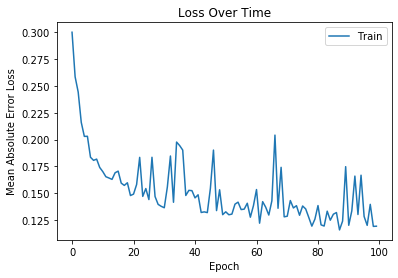

In [213]:
plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train'])

In [214]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        states_value = [h, c]

    return decoded_seq

In [218]:
[e_data,t_data]=create_encoder_target_pairs(train_data_as_array[5])
c = 0
pred_steps=3
preds=[]
for i in range(len(t_data[0])):
    edata = np.array([np.append(e_data[0],t_data[0][0:c])])
    encoder_input_data = edata
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    decoder_target_data = [t_data[0][c:c+pred_steps]]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    preds= np.append(preds,np.mean(decode_sequence(encoder_input_data)))
    c=c+1

Now, we look at the three-day moving average:

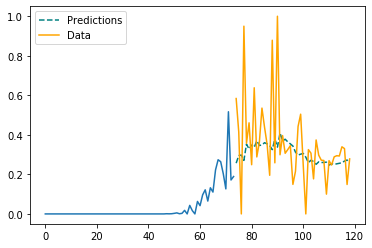

In [219]:
plt.plot(e_data[0])
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),preds,color='teal',linestyle='--', label='Predictions')
plt.plot(range(len(e_data[0]),len(e_data[0])+len(preds)),t_data[0],color='orange', label='Data')
plt.legend()
plt.show()

## Sources
1. https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
2. https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
3. https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb
4. https://www.kaggle.com/c/covid19-global-forecasting-week-5/data?select=test.csv
5. https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
6. https://wallethub.com/edu/states-with-the-fewest-coronavirus-restrictions/73818/